In [2]:
import torch
import numpy as np
from torch import optim
from scipy.stats import spearmanr
from torch.distributions.normal import Normal
import pandas as pd
import matplotlib.pyplot as plt


from misc import data, c
from models import *
from train_models import training

In [67]:
mu_wild[p-1][0,0],mu_wild[p-1][0,1]

(tensor(-24.1148, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-27.5835, device='cuda:0', grad_fn=<SelectBackward>))

Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 0.389s torch.Size([8403, 23, 253])
Calculating 8403 weights...
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.229s torch.Size([4807, 23, 253])


<ipython-input-3-f93c3e64a062>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutants_df['color'][mutants_df.value<0] = 'red'
<ipython-input-3-f93c3e64a062>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutants_df['size'][mutants_df.value>0] =  abs(np.round(mutants_df['value'].values*250))


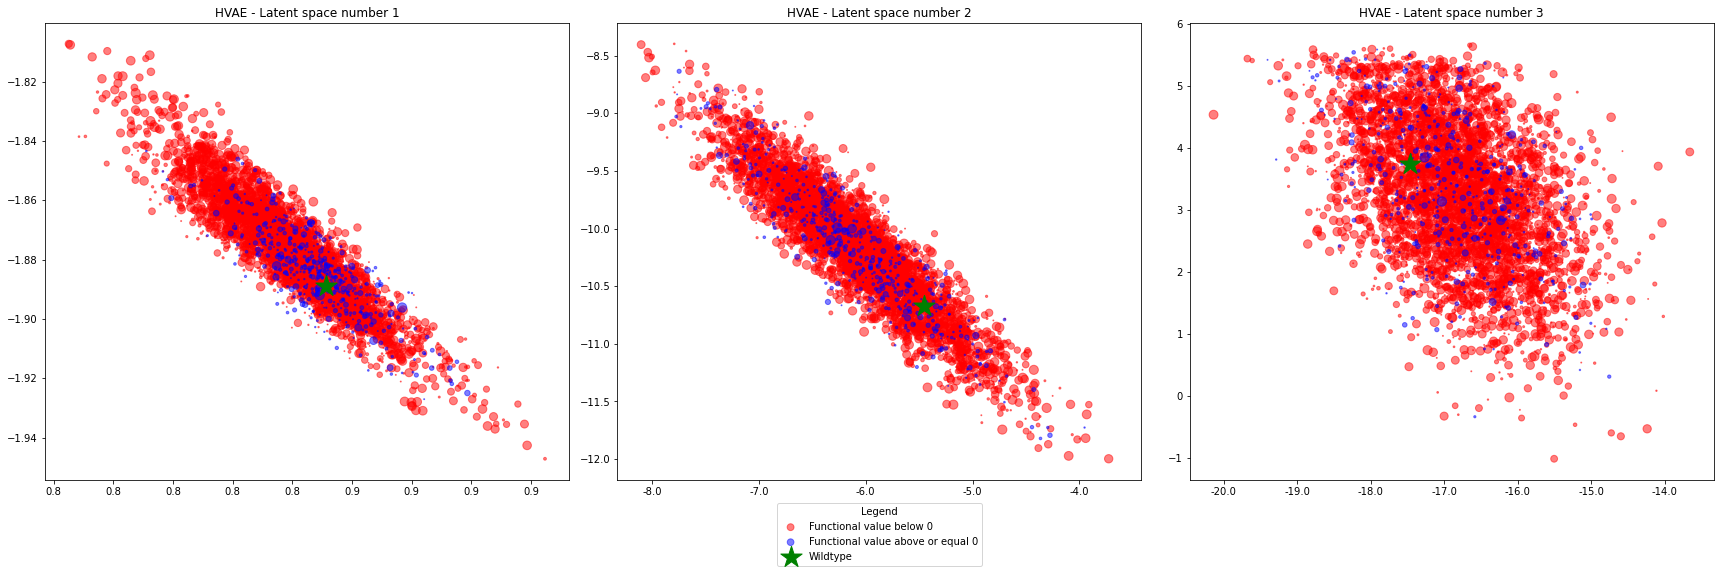

In [3]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader, df, mutants_tensor, mutants_df, weights, neff = data(batch_size = batch_size, neff_w = True, device = device)

wildtype   = dataloader.dataset[0] # one-hot-encoded wildtype 
eval_batch = torch.cat([wildtype.unsqueeze(0), mutants_tensor])

model_dict = torch.load('trained.model_HVAE_l2_exp.pth')
vae = HVAE(**model_dict['args']).to(device)
vae.load_state_dict(model_dict['state_dict'])
vae.eval()
_, _,_,_,_, mu_mut, _ = vae(eval_batch)

wildtype_mask = pd.Series(np.zeros((len(df)),dtype = bool))
wildtype_mask.iloc[0] = True
_,_,_,_,_, mu_wild, logvar_wild = vae(dataloader.dataset[wildtype_mask])

from matplotlib.ticker import StrMethodFormatter
mutants_df['color'] = 0
mutants_df['size'] = 0
mutants_df['color'][mutants_df.value<0] = 'red'
mutants_df['color'][mutants_df.value>0] = 'blue'
mutants_df['size'][mutants_df.value>0] =  abs(np.round(mutants_df['value'].values*250))
mutants_df['size'][mutants_df.value<0] =  abs(np.round(mutants_df['value'].values*25))
count = 1


plt.figure(figsize = (24,8))
for p in range(len(mu_mut),0,-1):
    plt.subplot(1,len(mu_mut),count)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # No decimal places
    columns = [str(i+1) for i in range(mu_mut[p-1].shape[1])] + ['label']
    dfp = pd.DataFrame(data=np.c_[mu_mut[p-1][1:,:].cpu().detach().numpy(), mutants_df.value], columns=columns)
    plt.scatter(mu_mut[p-1][1:,0][mutants_df.value <0].cpu().detach().numpy(),mu_mut[p-1][1:,1][mutants_df.value <0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value <0], 
                c = mutants_df['color'][mutants_df.value <0], alpha = 0.5, label = 'Functional value below 0')
    plt.scatter(mu_mut[p-1][1:,0][mutants_df.value >=0].cpu().detach().numpy(),mu_mut[p-1][1:,1][mutants_df.value >=0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value >=0], 
                c = mutants_df['color'][mutants_df.value >=0], alpha = 0.5, label = 'Functional value above or equal 0')
    
    #columns_wild = [str(i+1) for i in range(mu_wild[p-1].shape[1])] + ['label']
    #dfp_wild = pd.DataFrame(data = np.c_[mu_wild[p-1][1:,:].cpu().detach().numpy(), "Wildtype"], columns = columns)
    plt.scatter(mu_wild[p-1][0,0].cpu().detach().numpy(),mu_wild[p-1][0,1].cpu().detach().numpy(), s = 500, marker ="*",
               label = "Wildtype", c = "green")
    
    
    if p == 2:
        plt.legend(title='Legend', bbox_to_anchor=(0.5, -0.2), loc='lower center')
    plt.title('HVAE - Latent space number {}'.format(count))
    count+=1
plt.tight_layout()
plt.savefig('figures/HVAE_mutants.png')



In [4]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader, df, mutants_tensor, mutants_df, weights, neff = data(batch_size = batch_size, neff_w = True, device = device)

wildtype   = dataloader.dataset[0] # one-hot-encoded wildtype 
eval_batch = torch.cat([wildtype.unsqueeze(0), mutants_tensor])
mask = df['label'].isin(df['label'].value_counts()[:5].index) # We limit to top 5 classes only
model_dict = torch.load('trained.model_HVAE_l2_exp.pth')
vae = HVAE(**model_dict['args']).to(device)
vae.load_state_dict(model_dict['state_dict'])
vae.eval()
_, _,_,_,_, mu, _ = vae(eval_batch)
_,_,_,_,_,mu_w, _ = vae(dataloader.dataset[mask])


print()
for p in range(len(mu)):
  mu_w_t = mu_w[p].cpu().data.numpy()
  mu_t = mu[p].cpu().data.numpy()
  """
  u, s, vh = np.linalg.svd(mu_w_t)
  mu_w_t = (np.diag(1/s) @ vh @ mu_w_t.T).T
  u, s, vh = np.linalg.svd(mu_t)
  mu_t = (np.diag(1/s) @ vh @ mu_t.T).T
  """

  dist = torch.diag(torch.cdist(torch.from_numpy(mu_w_t[0,:]).reshape(-1,mu_t.shape[1]).repeat(4807,1), 
                                torch.from_numpy(mu_t[1:,:]))).cpu().data.numpy()
  print('HVAE- latentspace {}'.format(p+1),np.corrcoef(mutants_df.value.values,dist))



Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 0.398s torch.Size([8403, 23, 253])
Calculating 8403 weights...
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.231s torch.Size([4807, 23, 253])

HVAE- latentspace 1 [[ 1.         -0.00126277]
 [-0.00126277  1.        ]]
HVAE- latentspace 2 [[ 1.         -0.00987668]
 [-0.00987668  1.        ]]
HVAE- latentspace 3 [[ 1.        -0.1504727]
 [-0.1504727  1.       ]]


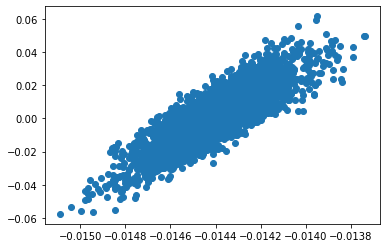

In [8]:
plt.scatter(x=mu_t[:,0],y = mu_t[:,1])

In [2]:
def plot_latents():
    
    batch_size = 128
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloader, df, mutants_tensor, mutants_df, weights, neff = data(batch_size = batch_size, neff_w = False, device = device)

    wildtype   = dataloader.dataset[0] # one-hot-encoded wildtype 
    eval_batch = torch.cat([wildtype.unsqueeze(0), mutants_tensor])

    """
    Plot of latent spaces using wildtypes and using mutants for Vanilla VAE
    """
    model_dict = torch.load('trained.model_vanilla.pth')
    mask = df['label'].isin(df['label'].value_counts()[:5].index) # We limit to top 5 classes only
    vae = VAE(**model_dict['args']).to(device)
    vae.load_state_dict(model_dict['state_dict'])
    vae.eval()
    _,mu, _ = vae(dataloader.dataset[mask])


    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    columns = [str(i+1) for i in range(mu.shape[1])] + ['label']
    dfp = pd.DataFrame(data=np.c_[mu.cpu().detach().numpy(), df[mask]['label']], columns=columns)
    dfp = dfp.set_index('1').groupby('label')['2']
    dfp.plot(style='.', ms=5, alpha=0.5, legend=True);
    plt.title('Vanilla VAE')

    plt.subplot(1,2,2)
    mutants_df['color'] = 0
    mutants_df['size'] = 0
    mutants_df['color'][mutants_df.value<0] = 'red'
    mutants_df['color'][mutants_df.value>0] = 'blue'
    mutants_df['size'][mutants_df.value>0] =  abs(np.round(mutants_df['value'].values*250))
    mutants_df['size'][mutants_df.value<0] =  abs(np.round(mutants_df['value'].values*25))
    _, mu,_= vae(eval_batch)
    columns = [str(i+1) for i in range(mu.shape[1])] + ['label']

    dfp = pd.DataFrame(data=np.c_[mu[1:,:].cpu().detach().numpy(), mutants_df.value], columns=columns)
    plt.scatter(mu[1:,0][mutants_df.value <0].cpu().detach().numpy(),mu[1:,1][mutants_df.value <0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value <0], 
              c = mutants_df['color'][mutants_df.value <0], alpha = 0.5, label = 'Functional value below 0')
    plt.scatter(mu[1:,0][mutants_df.value >=0].cpu().detach().numpy(),mu[1:,1][mutants_df.value >=0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value >=0], 
              c = mutants_df['color'][mutants_df.value >=0], alpha = 0.5, label = 'Functional value above or equal 0')
    plt.title('Vanilla VAE')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/vanilla_vae_latent.png')


    """
    Plot of latent spaces using wildtypes and using mutants for HVAE
    """
    dataloader, df, mutants_tensor, mutants_df, weights, neff = data(batch_size = batch_size, neff_w = True, device = device)

    wildtype   = dataloader.dataset[0] # one-hot-encoded wildtype 
    eval_batch = torch.cat([wildtype.unsqueeze(0), mutants_tensor])

    model_dict = torch.load('trained.model_HVAE_exp.pth')
    vae = HVAE(**model_dict['args']).to(device)
    vae.load_state_dict(model_dict['state_dict'])
    vae.eval()
    _, _,_,_,_, mu, _ = vae(eval_batch)

    from matplotlib.ticker import StrMethodFormatter
    mutants_df['color'] = 0
    mutants_df['size'] = 0
    mutants_df['color'][mutants_df.value<0] = 'red'
    mutants_df['color'][mutants_df.value>0] = 'blue'
    mutants_df['size'][mutants_df.value>0] =  abs(np.round(mutants_df['value'].values*250))
    mutants_df['size'][mutants_df.value<0] =  abs(np.round(mutants_df['value'].values*25))
    count = 1


    plt.figure(figsize = (24,8))
    for p in range(len(mu),0,-1):
        plt.subplot(1,len(mu),count)
        plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # No decimal places
        columns = [str(i+1) for i in range(mu[p-1].shape[1])] + ['label']
        dfp = pd.DataFrame(data=np.c_[mu[p-1][1:,:].cpu().detach().numpy(), mutants_df.value], columns=columns)
        plt.scatter(mu[p-1][1:,0][mutants_df.value <0].cpu().detach().numpy(),mu[p-1][1:,1][mutants_df.value <0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value <0], 
                    c = mutants_df['color'][mutants_df.value <0], alpha = 0.5, label = 'Functional value below 0')
        plt.scatter(mu[p-1][1:,0][mutants_df.value >=0].cpu().detach().numpy(),mu[p-1][1:,1][mutants_df.value >=0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value >=0], 
                    c = mutants_df['color'][mutants_df.value >=0], alpha = 0.5, label = 'Functional value above or equal 0')
        if p == 2:
          plt.legend(title='Legend', bbox_to_anchor=(0.5, -0.2), loc='lower center')
        plt.title('HVAE - Latent space number {}'.format(count))
        count+=1
    plt.tight_layout()
    plt.savefig('figures/HVAE_mutants.png')



    _,_,_,_,_, mu, logvar = vae(dataloader.dataset[mask])
    plt.figure(figsize = (24,8))
    count= 1
    for p in range(len(mu),0,-1):
        plt.subplot(2,len(mu),count)
        columns = [str(i+1) for i in range(mu[p-1].shape[1])] + ['label']
        dfp = pd.DataFrame(data=np.c_[mu[p-1].cpu().detach().numpy(), df[mask]['label']], columns=columns)
        dfp = dfp.set_index('1').groupby('label')['2']
        plt.title('HVAE - Latent space number {}'.format(count))
        dfp.plot(style='.', ms=6, alpha=0.5, legend=False);
        count+=1
        if p == 2:
          plt.legend(title='Legend', bbox_to_anchor=(0.5, -0.4), ncol = 5, loc='lower center', fontsize = 'large')
    plt.tight_layout()
    plt.savefig('figures/HVAE_wildtype.png')


    """
    Plot of latent spaces using wildtypes and using mutants for Bayesian-VAE

    """
    model_dict = torch.load('trained.model.bayesian_l2.pth')
    mask = df['label'].isin(df['label'].value_counts()[:5].index) # We limit to top 5 classes only
    vae = VAE_bayesian(**model_dict['args']).to(device)
    vae.load_state_dict(model_dict['state_dict'])
    vae.eval()
    _,mu, _ = vae(dataloader.dataset[mask])


    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    columns = [str(i+1) for i in range(mu.shape[1])] + ['label']
    dfp = pd.DataFrame(data=np.c_[mu.cpu().detach().numpy(), df[mask]['label']], columns=columns)
    dfp = dfp.set_index('1').groupby('label')['2']
    dfp.plot(style='.', ms=5, alpha=0.5, legend=True);
    plt.title('Bayesian VAE')

    _, mu, _ = vae(eval_batch)

    plt.subplot(1,2,2)
    columns = [str(i+1) for i in range(mu.shape[1])] + ['label']
    dfp = pd.DataFrame(data=np.c_[mu[1:,:].cpu().detach().numpy(), mutants_df.value], columns=columns)
    plt.scatter(mu[1:,0][mutants_df.value <0].cpu().detach().numpy(),mu[1:,1][mutants_df.value <0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value <0], 
              c = mutants_df['color'][mutants_df.value <0], alpha = 0.5, label = 'Functional value below 0')
    plt.scatter(mu[1:,0][mutants_df.value >=0].cpu().detach().numpy(),mu[1:,1][mutants_df.value >=0].cpu().detach().numpy(),s =mutants_df['size'][mutants_df.value >=0], 
              c = mutants_df['color'][mutants_df.value >=0], alpha = 0.5, label = 'Functional value above or equal 0')
    plt.title('Bayesian VAE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('figures/bayesian_vae_latent.png')